In [ ]:
# from google.colab import drive
# drive.mount("/content/drive")

# %cd /content/drive/MyDrive/chirpy
# !pip install .

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.io import loadmat
import matplotlib

from chirpy.geometry import ImageGrid2D, TransducerArray2D
from chirpy.data import AcquisitionData
from chirpy.data.image_data import ImageData
from chirpy.optimization.operator import WaveOperator
from chirpy.signals import GaussianModulatedPulse

# matplotlib.use("TkAgg")

Original model shape: (1601, 1601)
Downsampled model shape: (240, 240)
record_time = 0.22 ms


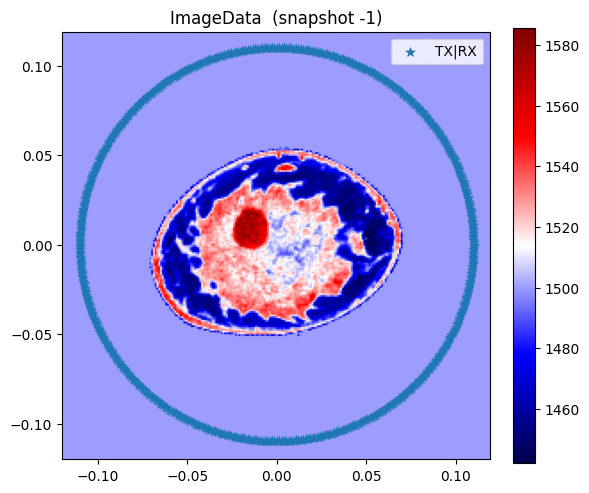

<Axes: title={'center': 'ImageData  (snapshot -1)'}>

In [3]:
# Settings
ROOT_DIR = Path("/Users/elliottmacneil/python/chirpy")
DATA_DIR = Path(ROOT_DIR / "data")
SAVE_DIR = Path(ROOT_DIR / "outputs")
SAVE_DIR.mkdir(exist_ok=True, parents=True)

# Lower frequency & coarse grid
f0 = 0.3e6  # Center frequency 0.3 MHz
Nx = Ny = 240  # Number of grid points
dx = dy = 1.0e-3  # Grid spacing 1 mm
c0 = 1500.0

# (1) Load and downsample true sound-speed model
mat = loadmat(DATA_DIR / "C_true.mat")
model_raw = mat["C_true"]  # Original (1601,1601)
print("Original model shape:", model_raw.shape)

# (2) make ImageGrid2D and compute record time
img_grid = ImageGrid2D(nx=Nx, ny=Ny, dx=dx)

# Downsample using ImageGrid2D
img_raw = ImageData(model_raw)
img_true = img_raw.downsample_to(new_grid=img_grid)
model_true = img_true.array
print("Downsampled model shape:", model_true.shape)
c_ref = model_true.max()

# Compute record time
extent = img_grid.extent
c_min = float(model_true.min())
record_time = 1.3 * (extent[1] - extent[0]) / c_min
print(f"record_time = {record_time * 1e3:.2f} ms")

# (3) Construct 512-element ring array & mask
n_tx = 512
radius = 110e-3  # 110 mm
tx_array = TransducerArray2D.from_ring_array_2D(r=radius, grid=img_grid, n=n_tx)

# (4) AcquisitionData
acq_data = AcquisitionData.from_geometry(tx_array=tx_array, grid=img_grid)

# (5) Visualize true sound speed + sensors
true_image_data = ImageData(array=model_true, tx_array=tx_array, grid=img_grid)
true_image_data.show()



In [ ]:
# (6) Construct WaveOperator
medium_params = {
    "sound_speed": model_true.astype(np.float32),
    "density": np.ones((Ny, Nx), np.float32) * 1000.0,
    "alpha_coeff": np.zeros((Ny, Nx), np.float32),
    "alpha_power": 1.01,
    "alpha_mode": "no_dispersion",
}

pulse = GaussianModulatedPulse(f0=f0, frac_bw=0.75, amp=1.0)

op_true = WaveOperator(
    data=acq_data,
    medium_params=medium_params,
    record_time=record_time,
    record_full_wf=False,
    use_encoding=False,
    drop_self_rx=True,
    pulse=pulse,
    c_ref=c_ref,
    use_tqdm=True
)

# (7) Synthesize observations & save
fname = SAVE_DIR / f"d_obs_240x240_1mm_0p3MHz_new_512.npz"

acq_sim = op_true.simulate()
acq_sim.save(fname)
